In [1]:
#Common import for data manipulation
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.signal import decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#Importing keras to build neural network
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2

Using TensorFlow backend.


In [2]:
# Directory of datasets
DAT_DIR = 'heartbeat-sounds/'
SET_A = 'set_a.csv'
SET_B = 'set_b.csv'

In [3]:
#Functions used to help prepare data for Machine Learning

def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name

def clean_filename_b(fname):
    filename = fname.replace('Btraining_','')
    filename = filename.split('/')[1]
    if filename.find('noisy') != -1:
        return filename
    else:
        _ = filename.find('_')
        filename = filename[0:_] + '__' + filename[_+1:]
        return filename

def load_wav_file(name, path):
    _ , b = wavfile.read(path + name)
    #assert _ == SAMPLE_RATE
    return b

def load_wav_file_rate(name, path):
    a, b = wavfile.read(path + name)
    #assert _ == SAMPLE_RATE
    return a

def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = 'float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def prepped_df(old_df):
    df = old_df.copy()

    df['fname'] = df['fname'].apply(clean_filename, string='Aunlabelledtest')
    df['label'] = df['label'].fillna(value = 'unclassified')
    df['time_series'] = df['fname'].apply(load_wav_file, path=DAT_DIR + '/set_a/')
    df['len_series'] = df['time_series'].apply(len)
    MAX_LEN = max(df['len_series'])
    df['time_series'] = df['time_series'].apply(repeat_to_length, length=MAX_LEN)
    return df

In [4]:
df_a = pd.read_csv(DAT_DIR + SET_A)
df_b = pd.read_csv(DAT_DIR + SET_B)

df = prepped_df(df_a)

In [5]:
#df = df[df['label'] != 'unclassified']

In [6]:
x_data = np.stack(df['time_series'].values, axis=0)
y_data = df['label']

In [7]:
#yy = y_data.copy()

In [8]:
#yy_enc, yy_str = yy.factorize()
#
#encoder_1H = OneHotEncoder()
#
#yy_1h = encoder_1H.fit_transform(yy_enc.reshape(-1,1))

In [9]:
#y_data = yy_1h.toarray()

In [10]:
new_labels =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1,
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1,
             2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1,
             1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 1, 1, 1,
             0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0,
             1, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
new_labels = np.array(new_labels, dtype='int')

y_data = np_utils.to_categorical(new_labels)

In [11]:
x_train, x_test, y_train, y_test, train_filenames, test_filenames = \
    train_test_split(x_data, y_data, df['fname'].values, test_size=0.25, random_state = 42)
    

In [12]:
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 8, axis=1, zero_phase=True)
x_train = decimate(x_train, 4, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 8, axis=1, zero_phase=True)
x_test = decimate(x_test, 4, axis=1, zero_phase=True)


x_train = x_train / np.std(x_train, axis=1).reshape(-1,1)
x_test = x_test / np.std(x_test, axis=1).reshape(-1,1)



x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]


In [20]:
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(3, activation='softmax'))

In [21]:
def batch_generator(x_train, y_train, batch_size):
    """
    Rotates the time series randomly in time
    """
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0])

    while True:
        batch_idx = np.random.choice(full_idx, batch_size)
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]

        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)

        yield x_batch, y_batch


In [22]:
weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss',
                               save_best_only=True, save_weights_only=True)

In [23]:
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

In [25]:
hist = model.fit_generator(batch_generator(x_train, y_train, 8),
                   epochs=30, steps_per_epoch=1000,
                   validation_data=(x_test, y_test),
                   callbacks=[weight_saver, annealer],
                   verbose=2)

Epoch 1/30
 - 16s - loss: 1.9238 - acc: 0.4969 - val_loss: 1.2358 - val_acc: 0.7273
Epoch 2/30
 - 14s - loss: 1.2090 - acc: 0.6594 - val_loss: 0.8770 - val_acc: 0.8409
Epoch 3/30
 - 15s - loss: 0.9410 - acc: 0.7166 - val_loss: 0.7143 - val_acc: 0.8182
Epoch 4/30
 - 16s - loss: 0.8201 - acc: 0.7332 - val_loss: 0.5856 - val_acc: 0.8409
Epoch 5/30
 - 14s - loss: 0.7383 - acc: 0.7591 - val_loss: 0.5230 - val_acc: 0.8409
Epoch 6/30
 - 15s - loss: 0.6714 - acc: 0.7826 - val_loss: 0.4967 - val_acc: 0.8636
Epoch 7/30
 - 15s - loss: 0.6199 - acc: 0.7944 - val_loss: 0.4525 - val_acc: 0.8182
Epoch 8/30
 - 15s - loss: 0.5993 - acc: 0.7974 - val_loss: 0.4584 - val_acc: 0.7955
Epoch 9/30
 - 15s - loss: 0.5866 - acc: 0.8036 - val_loss: 0.4506 - val_acc: 0.7955
Epoch 10/30
 - 15s - loss: 0.5639 - acc: 0.8155 - val_loss: 0.4128 - val_acc: 0.7955
Epoch 11/30
 - 15s - loss: 0.5573 - acc: 0.8151 - val_loss: 0.4063 - val_acc: 0.8182
Epoch 12/30
 - 15s - loss: 0.5531 - acc: 0.8215 - val_loss: 0.3890 - val_a

In [26]:
model.load_weights('set_a_weights.h5')

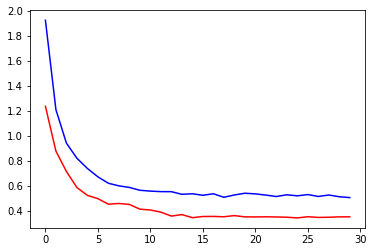

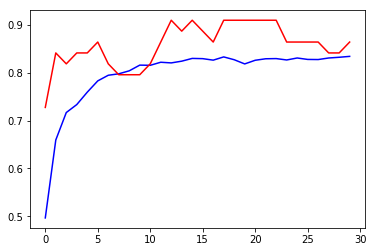

In [27]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()